In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt 
import seaborn as sns
#from googletrans import Translator

# Read Initial DataSet

In [2]:
# use chunksize to avoi prloblems with big files
twittes = pd.DataFrame(columns=["text","timestamp","likes" , "retweets" ,"replies"])
i=0
chunksize = 10 ** 6
for chunk in pd.read_csv("tweets.csv", chunksize=chunksize  ,sep=';' , engine='python'   ):

    chunk['timestamp']  = pd.to_datetime(chunk['timestamp'] , errors='coerce')

    chunktimp = chunk.loc[ : ,["text","timestamp","likes" , "retweets","replies"] ]
    
    twittes= pd.concat([twittes,chunktimp] ,ignore_index= True)
    i=i+1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [10]:
len(twittes)

16890422

Check Nan Values

In [3]:
# print(twittes.isna().sum())
twittes.dropna(inplace=True)
# print(twittes.isna().sum())

To Translate other language text to english

In [ ]:
not_en = []
for i in twittes.index:

    if(model.predict(twittes.loc[i,"text"])[0][0].split("__")[-1] =="en"):
       not_en.append(i)

    if i % 10000 == 0:
        print(i)

In [ ]:
len(not_en)

13802716

In [ ]:
twittes.drop(not_en, axis=0, inplace=True)

In [ ]:
twittes.to_csv("EnTwittes.csv")

In [23]:
# def Translate(df):
#     print(df.name)
#     translator = Translator()
#     if(translator.detect(df["text"]) != 'en'):
#         return translator.translate(df["text"], dest='en').text
#     else :
#          return df["text"]


In [1]:
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
# translator = Translator()
# twittes["lan"]= twittes["text"].parallel_apply(lambda s :  translator.detect(s))

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
# twittes["text"]= twittes.apply(lambda row : Translate(row) ,axis=1)

# Clean Text

In [4]:
#Clean Twittes Text
twittes["text"].replace(r'(http|https|ftp)://[a-zA-Z0-9\\./]+','',regex=True, inplace = True)
twittes["text"].replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',regex=True, inplace = True)
twittes["text"].replace("[^a-zA-Z]",' ',regex=True, inplace = True)
twittes["text"].replace(r'\s+',' ',regex=True, inplace = True)
twittes['text'] = twittes['text'].str.lower()

In [5]:
twittes['timestamp'] = pd.to_datetime(twittes['timestamp']).dt.date

In [6]:
print(twittes.isna().sum())
# twittes.dropna(inplace=True)
# print(twittes.isna().sum())

text         0
timestamp    0
likes        0
retweets     0
replies      0
dtype: int64


In [ ]:
#Save the Twiiter DataFrame
# twittes.to_csv("Twittes_Clean.csv")

# Create weight for each twitte based on number of likes and retweets and replies

In [6]:
twittes['Sum'] = twittes["likes"] + twittes["retweets"] +twittes["replies"]

In [7]:
DaySum =  twittes.groupby(["timestamp"])["Sum"].agg('sum')
DaySum

timestamp
2007-04-19         2.0
2009-01-11       20802
2009-01-21      1991.0
2009-01-27      1363.0
2009-01-29        44.0
                ...   
2019-11-19    198590.0
2019-11-20    199064.0
2019-11-21    326145.0
2019-11-22    205353.0
2019-11-23     42819.0
Name: Sum, Length: 3005, dtype: object

In [8]:
#Calculate the sum avrage for each twitte within the day
#
#
# formula --->  sum(likes + retweets + replies) for i twitte in a day   /   sum(likes + retweets + replies) for all twitte in this day
# but avoid to divid by 0
def Calaulte_Wight (row):
  if( DaySum[row.timestamp] !=0 ):
     result = round(row.Sum / DaySum[row.timestamp],3)
  else :
   result =0
  return result

In [46]:
twittes["weight"] = twittes.apply(Calaulte_Wight , axis=1)

c:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


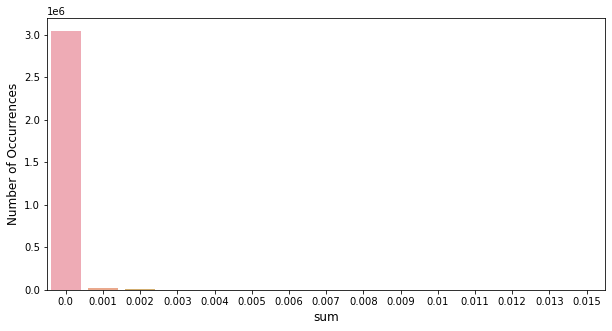

In [47]:
freque_count = twittes['weight'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sum', fontsize=12)
plt.show()

because of so many twittes has wieght == 0 we will assign fixed weight for them because we don't want to lose so many information 

In [48]:
twittes.loc[twittes["weight"] < 0.1  ,"weight"] = 0.1

In [ ]:
#Save the Twiiter DataFrame
twittes.loc[:,["text","timestamp","weight"]].to_csv("CleanTwittes_Wieght.csv")

In [ ]:
# twittes = pd.read_csv("CleanTwittes_Wieght.csv")
# twittes=twittes.drop(["Unnamed: 0"],axis=1)
# twittes['date'] = pd.to_datetime(twittes['date']).dt.date
# twittes

In [ ]:
# twittes['date']
# twittes.sort_values(by='date', ascending=True)
# a= twittes['date'].unique()
# print(sorted(a))
# print(len(twittes['date'].unique()))

# VADER

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

perform VADER method on the text predouce polarity score between [-1 , 1]

In [41]:
SentimentScore = [] 
for text in twittes['text']:
    SentimentScore.append(  [sid_obj.polarity_scores(text)['compound'] , sid_obj.polarity_scores(text)['neg'] ,sid_obj.polarity_scores(text)['neu'] , sid_obj.polarity_scores(text)['pos'] ])
SentimentScore

[[0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [-0.296, 0.078, 0.922, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [-0.5267, 0.099, 0.901, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [-0.8316, 0.302, 0.698, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.4215, 0.0, 0.263, 0.737],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.

In [42]:
len(SentimentScore)

3086236

In [43]:
twittes[["Sentiment_Score","neg",'neu' , "pos"]] = SentimentScore
twittes

,text,timestamp,likes,retweets,replies,Sum,weight,Sentiment_Score,neg,neu,pos
0,appena uscito un nuovo video les cryptomonnai...,2019-05-27,0,0,0,0,0.1,0.0,0.0,1.0,0.0
5,btc inceldii yerden kopsun bakalm ye kadar bir...,2019-05-27,0,0,0,0,0.1,0.0,0.0,1.0,0.0
7,como investidor vc um timo dev sorte q eu com...,2019-05-27,0,0,0,0,0.1,0.0,0.0,1.0,0.0
20,hot hot hot,2019-05-26,28,4,1,33,0.1,0.0,0.0,1.0,0.0
24,outro grande banco holands abandona lanamento...,2019-05-27,0,0,0,0,0.1,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16890395,crex,2019-11-23,0.0,0.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0
16890397,btcptkt,2019-11-23,0.0,0.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0
16890404,la tecnologa blockchain puede ser aplicada en ...,2019-11-23,0.0,0.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0
16890408,la tecnologa blockchain puede ser aplicada en ...,2019-11-23,0.0,0.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0


c:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


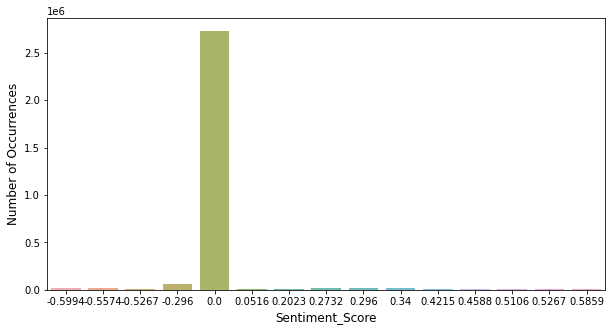

In [44]:
freque_count = twittes['Sentiment_Score'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment_Score', fontsize=12)
plt.show()

# Check twittes with score == 0 if english or not

In [22]:
import fasttext
# dowenload model
#wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [23]:
PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [14]:
# Score_0 = twittes[twittes["Sentiment_Score"]==0]

# Create Withted_Score by multiply score and Wight

In [50]:
twittes["Withted_Score"] = round(twittes["Sentiment_Score"] *  twittes["weight"],3) 

c:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


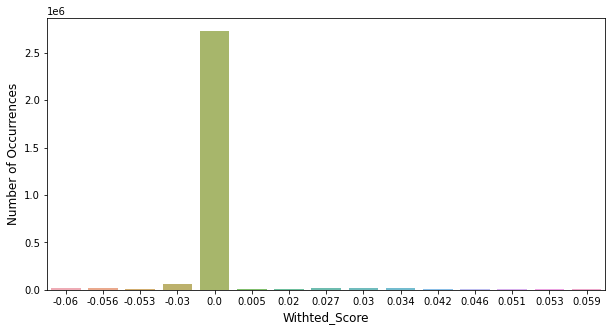

In [51]:
freque_count = twittes['Withted_Score'].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(freque_count.index, freque_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Withted_Score', fontsize=12)
plt.show()

In [62]:
#Save to DataFrame
twittes.loc[:,["timestamp","weight" ,"Withted_Score","neg",'neu' , "pos" ,"Sentiment_Score"]].to_csv("Twittes_Withted_Score_En2.csv")

# Work With Prices

In [53]:
#Read Bitcoin Data
BitCoin_prices =  pd.read_csv("BTC-USD.csv" , parse_dates=["Date"], infer_datetime_format = True)
BitCoin_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800
...,...,...,...,...,...,...,...
2317,2022-07-16,20834.103516,21514.404297,20518.898438,21190.316406,21190.316406,24302954056
2318,2022-07-17,21195.041016,21600.640625,20778.179688,20779.343750,20779.343750,22927802083
2319,2022-07-18,20781.912109,22633.033203,20781.912109,22485.689453,22485.689453,39974475562
2320,2022-07-19,22467.849609,23666.962891,21683.406250,23389.433594,23389.433594,48765202697


In [54]:
#Remove the time from the date
BitCoin_prices['Date'] = pd.to_datetime(BitCoin_prices['Date']).dt.date
BitCoin_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800
...,...,...,...,...,...,...,...
2317,2022-07-16,20834.103516,21514.404297,20518.898438,21190.316406,21190.316406,24302954056
2318,2022-07-17,21195.041016,21600.640625,20778.179688,20779.343750,20779.343750,22927802083
2319,2022-07-18,20781.912109,22633.033203,20781.912109,22485.689453,22485.689453,39974475562
2320,2022-07-19,22467.849609,23666.962891,21683.406250,23389.433594,23389.433594,48765202697


# map Bitcoin With Sentiment score

In [56]:
data = twittes.groupby(["timestamp"])["Withted_Score" , "Sentiment_Score" ,"weight" ,"neg",'neu' , "pos"].agg('mean')
# data= pd.DataFrame({'date':data.index, 'score':data.values})
data

C:\Users\admin\AppData\Local\Temp\ipykernel_10280\622587744.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = twittes.groupby(["timestamp"])["Withted_Score" , "Sentiment_Score" ,"weight" ,"neg",'neu' , "pos"].agg('mean')


,Withted_Score,Sentiment_Score,weight,neg,neu,pos
timestamp,,,,,,
2010-12-08,0.000000,0.000000,1.000,0.000000,1.000000,0.000000
2011-05-16,0.030000,0.296000,0.100,0.000000,0.476000,0.524000
2011-06-11,0.000000,0.000000,0.100,0.000000,1.000000,0.000000
2011-06-16,0.000000,0.000000,0.111,0.000000,1.000000,0.000000
2011-06-21,0.000000,0.000000,0.125,0.000000,1.000000,0.000000
...,...,...,...,...,...,...
2019-11-19,0.000568,0.005779,0.100,0.008688,0.971188,0.020123
2019-11-20,0.000740,0.007499,0.100,0.008806,0.971880,0.019313
2019-11-21,-0.000079,-0.000660,0.100,0.011101,0.969384,0.019513


In [57]:
BitCoin_prices.rename(columns = {'Date':'timestamp'}, inplace = True)


In [58]:
Price_Score = BitCoin_prices.merge(data, on=['timestamp'])

In [59]:
Price_Score

,timestamp,Open,High,Low,Close,Adj Close,Volume,Withted_Score,Sentiment_Score,weight,neg,neu,pos
0,2016-03-12,421.605011,421.795013,410.093994,411.623993,411.623993,92712896,0.000000,0.000000,0.1,0.000000,1.000000,0.000000
1,2016-03-13,411.648010,416.604004,411.641998,414.065002,414.065002,74322800,0.000000,0.000000,0.1,0.000000,1.000000,0.000000
2,2016-03-14,414.200989,416.683990,414.200989,416.437988,416.437988,95259400,0.000180,0.001829,0.1,0.001876,0.995876,0.002247
3,2016-03-15,416.388000,418.131012,414.984985,416.829987,416.829987,66781700,-0.000303,-0.002990,0.1,0.001465,0.998535,0.000000
4,2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800,0.000463,0.004636,0.1,0.000000,0.998084,0.001916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2019-11-19,8305.134766,8408.516602,8099.963379,8206.145508,8206.145508,21083613816,0.000568,0.005779,0.1,0.008688,0.971188,0.020123
1348,2019-11-20,8203.613281,8237.240234,8010.511719,8027.268066,8027.268066,20764300437,0.000740,0.007499,0.1,0.008806,0.971880,0.019313
1349,2019-11-21,8023.644531,8110.098145,7597.381836,7642.750000,7642.750000,22514243371,-0.000079,-0.000660,0.1,0.011101,0.969384,0.019513
1350,2019-11-22,7643.569336,7697.382813,6936.706543,7296.577637,7296.577637,34242315785,0.000292,0.003010,0.1,0.010489,0.969255,0.020255


In [60]:
Price_Score.to_csv("Final_Data2.csv")

# Scrape

In [53]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
attributes_container = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(Bitcoin OR BTC OR bitcoin ) since:2019-01-01 until:2019-12-12  lang:en').get_items()):
    print(i)
    if i>5000:
        break
    attributes_container.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(attributes_container, columns=["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
tweets_df

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,CryptoPressNews,2019-12-11 23:59:56+00:00,1,CR_to_twitter,$BTC | #BTC - bitcoin's Current Price: ▲ $7217...
1,mightybitcoin,2019-12-11 23:57:52+00:00,2,Twitter Web App,BitPay now lets merchants accept three stablec...
2,jasonclements,2019-12-11 23:55:58+00:00,0,TweetDeck,Dear @CashApp All I want for Christmas is:\n\n...
3,Cafebitcoinorg,2019-12-11 23:55:50+00:00,0,Twitter for iPhone,Giá Bitcoin: Chữ thập vàng ‘huyền thoại’ có th...
4,CryptoBullGod,2019-12-11 23:54:08+00:00,1,Twitter for iPhone,1 key difference i am noting this yr vs last y...
...,...,...,...,...,...
4996,CryptoBitsNews1,2019-12-10 16:27:51+00:00,0,posts for my blog,Tezos Price Analysis: Continuous Growth \nTezo...
4997,justin_gesso,2019-12-10 16:26:25+00:00,1,Cloohawk,Are bitcoin sellers back in control? The crypt...
4998,CryptoAsAWay,2019-12-10 16:25:40+00:00,0,Twitter for Android,#crypto\n#cryptocurrency\n#cryptocurrencies\n#...
4999,davidmoadel,2019-12-10 16:25:23+00:00,0,Twitter Web App,$BTC #Bitcoin halving/halvening Are you ready?...


In [52]:
tweets_df['Date Created'] = pd.to_datetime(tweets_df['Date Created']).dt.date

print(tweets_df['Date Created'].unique())

[datetime.date(2019, 12, 11) datetime.date(2019, 12, 10)]
